In [6]:
%load_ext lab_black
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from scipy.stats import pearsonr

matplotlib.rcParams["font.family"] = ["Liberation Sans"]

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# Question we seek to answer
1. For LDL in all populations, $R^2$ increase with PC1, but coverage is ok.
2. For LDL in WB populations, $R^2$ increase with sex, but coverage is ok.
3. For BMI in WB populations, $R^2$ increase with sex, but coverage is ok.

the observation in LDL is due to the var(x). because R2 is a function of var(x) even if var(e) is the same across all covariates. write this into supp. notes / methods. posterior check should also be written into supp. notes. question: does this still happen if i do not include PGS x PC1 into the model? (compare R2 between w/o PGSxPC1 and w. PGSxPC1, or directly compare the figure) we should do the comparison just by varying this. This can also be added to the supp. notes.

For LDL, the ground truth is that the residual noise are similar across PC1 groups. But the slope is different across groups.

If PGS (PC1 + 1) is modeled, then it will capture that.

Otherwise if variable slope, the residual noise are still similar (maybe a bit larger than the scenraio where variable slope is not modeled)

more

- $R^2$ between polygenic score and trait is $R^2(y, \widehat{y})$. 
- Under a model of $y = \widehat{y} + e$. Interpretation being that the true phenotype floats around the point predictions. Or we understand this as: for all individuals with the same point predictions, the phenotypes follow a normal distribution around point predictions.
- $R^2$ is $R^2(\widehat{y} + e, \widehat{y}) = \frac{\text{Var}[\widehat{y}]}{\text{Var}[\widehat{y}] + \text{Var}[e]}$. Therefore, under this model, even when prediction interval length is held constant, i.e. $\text{Var}[e]$ is constant, variable $R^2$ will derive from variable $\text{Var}[\widehat{y}]$ across groups.
- Such variable $\text{Var}[\widehat{y}]$ can come from multiple factors. One of important sources is because has variable slope.

We verify this in several examples. And we additionally provide simulations showcasing predictive checks that this can happen even when  

In [7]:
# setup (so this notebook can be run for trait-group repeatedly)
trait = "LDL"
group = "all"

# This hypothesis can be validated using predictive checks

In [8]:
def predictive_check(trait, group, covar):
    dict_r2 = dict()
    for method in ["mean", "mean+var"]:
        r2_list = []
        for seed in range(1, 31):
            df = pd.read_csv(
                f"out/model/{trait}-{group}/{seed}-{method}.test_info.tsv",
                sep="\t",
                index_col=0,
            )
            df_params = pd.read_csv(
                f"out/model/{trait}-{group}/{seed}-{method}.param.tsv",
                sep="\t",
                index_col=0,
            )
            if len(df[covar].unique()) > 5:
                df["q"] = pd.qcut(df[covar], q=5).cat.codes
            else:
                df["q"] = df[covar].values

            df["pheno_sim"] = np.random.normal(
                loc=df["cal_pred"], scale=df["cal_predstd"]
            )
            r2 = df.groupby("q").apply(
                lambda dfq: stats.pearsonr(dfq["cal_pred"], dfq["pheno_sim"])[0] ** 2
            )
            r2_list.append(r2)
        r2_list = pd.concat(r2_list, axis=1).T
        dict_r2[method] = r2_list

    fig, axes = plt.subplots(figsize=(6, 3), dpi=150, ncols=2, sharey=True)
    for i, method in enumerate(["mean", "mean+var"]):
        ax = axes[i]
        ax.boxplot(dict_r2[method], notch=True)
        ax.set_title(method, fontsize=11)
        ax.set_xlabel(covar)
    fig.suptitle(f"{trait}, {group}", y=0.9)
    fig.tight_layout()
    fig.show()

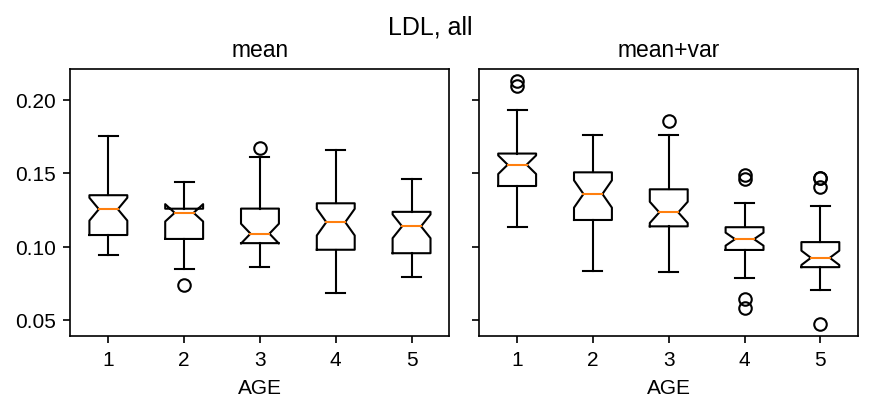

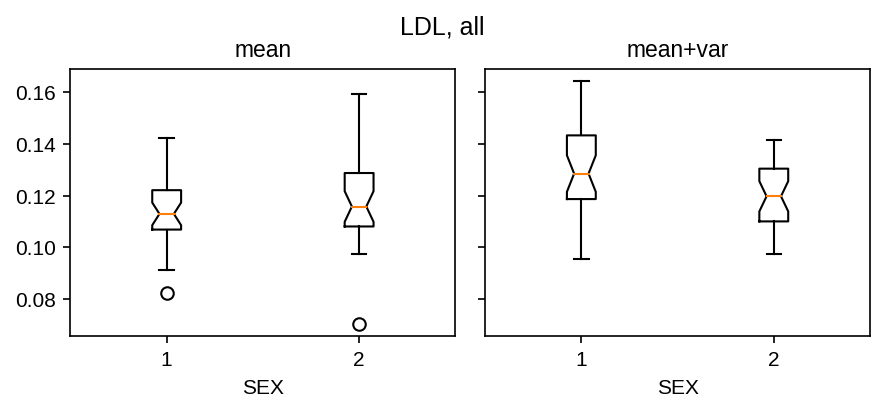

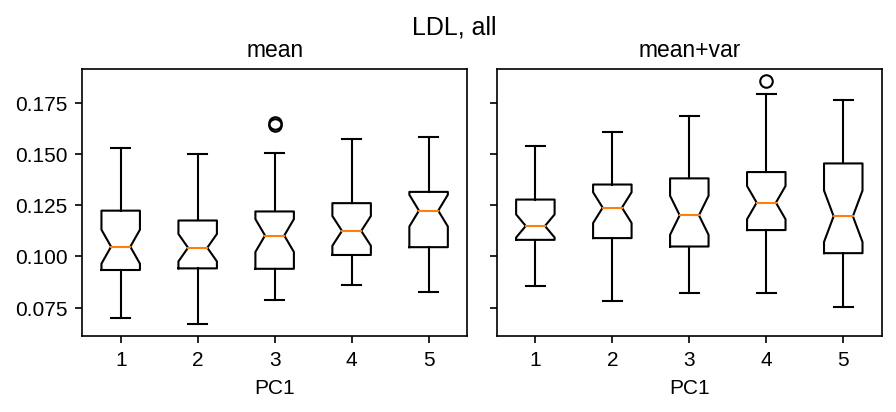

In [9]:
for covar in ["AGE", "SEX", "PC1"]:
    predictive_check(trait="LDL", group="all", covar=covar)

# This can also be validated using numerical evidence

- Stratify regression analysis between $y$ and $\widehat{y}$ across age/sex/PC1
- Stratify regression analysis between $y$ and individual covariates age/sex/PC1 (print top covariates)

In [30]:
def regression(trait, group, covar):
    method = "mean+var"
    df_stats_list = []
    for seed in range(1, 31):
        df = pd.read_csv(
            f"out/model/{trait}-{group}/{seed}-{method}.test_info.tsv",
            sep="\t",
            index_col=0,
        )
        if len(df[covar].unique()) > 5:
            df["q"] = pd.qcut(df[covar], q=5).cat.codes
        else:
            df["q"] = df[covar].values

        df_stats = {
            "r2": [],
            "std(resid)": [],
            "std(fitted_resid)": [],
            "std(pred)": [],
            "std(y)": [],
        }

        for i, (q, dfq) in enumerate(df.groupby("q")):
            x, y = dfq["cal_pred"], dfq["pheno"]
            model = sm.OLS(endog=y, exog=sm.add_constant(x)).fit()
            df_stats["r2"].append(model.rsquared)
            df_stats["std(resid)"].append(np.std(model.resid))
            df_stats["std(fitted_resid)"].append(np.std(y - x))
            df_stats["std(pred)"].append(np.std(x))
            df_stats["std(y)"].append(np.std(y))
        df_stats = pd.DataFrame(df_stats)
        df_stats_list.append(df_stats)

    df_stats = pd.DataFrame(
        np.mean(df_stats_list, axis=0),
        index=df_stats_list[0].index,
        columns=df_stats_list[0].columns,
    )
    return df_stats

In [39]:
trait, group = "LDL", "all"
seed = 1
method = "mean+var"

In [44]:
df_params = pd.read_csv(
    f"out/model/{trait}-{group}/{seed}-{method}.param.tsv",
    sep="\t",
    index_col=0,
)

In [45]:
df_params

,mean_beta,var_beta
const,3.517379,-0.453527
PGS,0.273444,0.166333
AGE,0.052637,0.162004
SEX,-0.086522,0.022546
DEPRIVATION_INDEX,-0.028623,0.032419
log_BMI,0.082027,0.114365
income,0.010115,-0.054915
ever_smoked,-0.000538,0.039842
drink_alcohol,0.028215,-0.008712
PC1,-0.016320,0.056655


In [35]:
for covar in ["PC1", "AGE", "SEX"]:
    print(f"# {covar}")
    display(regression("LDL", "all", covar))

# PC1


,r2,std(resid),std(fitted_resid),std(pred),std(y)
0,0.154132,0.795947,0.796534,0.351023,0.865547
1,0.142292,0.807226,0.808088,0.353308,0.871705
2,0.146080,0.795988,0.796549,0.349172,0.861433
3,0.146256,0.803642,0.804138,0.332184,0.869821
4,0.083702,0.809007,0.811179,0.292817,0.845200


# AGE


,r2,std(resid),std(fitted_resid),std(pred),std(y)
0,0.203785,0.709177,0.709618,0.370977,0.794835
1,0.163901,0.752379,0.752871,0.318835,0.822924
2,0.129582,0.807926,0.808399,0.309053,0.866073
3,0.116877,0.853157,0.853713,0.328548,0.907923
4,0.110053,0.873048,0.875823,0.368703,0.925553


# SEX


,r2,std(resid),std(fitted_resid),std(pred),std(y)
0,0.163067,0.792735,0.793256,0.370823,0.866540
1,0.110113,0.816223,0.816671,0.298638,0.865299


In [36]:
for covar in ["PC1", "AGE", "SEX"]:
    print(f"# {covar}")
    display(regression("height", "all", covar))

# PC1


,r2,std(resid),std(fitted_resid),std(pred),std(y)
0,0.721316,4.878921,4.880902,7.768585,9.245027
1,0.723237,4.861613,4.865405,7.798162,9.244801
2,0.723341,4.877291,4.879075,7.821458,9.276080
3,0.687827,5.164796,5.167314,7.697015,9.250455
4,0.627559,5.546394,5.558699,7.499540,9.094314


# AGE


,r2,std(resid),std(fitted_resid),std(pred),std(y)
0,0.678591,5.300082,5.302531,7.740830,9.352005
1,0.690563,5.185700,5.189651,7.763076,9.327650
2,0.710328,4.980101,4.982710,7.784548,9.256567
3,0.712709,4.941826,4.944707,7.772724,9.225005
4,0.708427,4.936730,4.941017,7.777545,9.146055


# SEX


,r2,std(resid),std(fitted_resid),std(pred),std(y)
0,0.430171,4.897012,4.898766,4.269776,6.487685
1,0.426855,5.299673,5.301393,4.571090,7.001232
